Title: Parametric Classifiers
Author: Thomas Breuel
Institution: UniKL

In [1]:

from numpy import *
from scipy import *
from pylab import *

In [2]:
coords = array(meshgrid(linspace(-5,5,200),linspace(-5,5,200)))
coords = transpose(coords,[1,2,0])
grid = coords.reshape([prod(coords.shape[:-1]),coords.shape[-1]])
def G(a): return a.reshape(coords.shape[:2])

Gaussian Densities
==================

Let's start by defining a function computing a Gaussian density:

$$ p(x;\mu,\Sigma) = ((2\pi)^{d/2} |\Sigma_i|)^{-1} e^{-\frac{1}{2}(x-\mu_i)\cdot \Sigma_i^{-1} \cdot (x-\mu_i)} $$

In [3]:
def normal(x,a,sigma):
    invsigma = inv(sigma)
    d = len(x[0])
    delta = x-a[newaxis,:]
    raw = exp(-0.5*sum(delta*dot(invsigma,delta.T).T,axis=1))
    result = raw * (linalg.det(invsigma) / (2*pi)**d)**0.5
    return result

There is a second kind of function we need, namely a function that generates random samples
from a normal density. 

We don't define that here, we just use a library function.

In [4]:
from numpy.random import multivariate_normal as N

A Two-Class Problem with Normal Densities
=========================================

Consider a two class problem:

$p(x|c=0) = {\cal N}(x;\mu_0,\Sigma_0)$

$p(x|c=1) = {\cal N}(x;\mu_1,\Sigma_1)$

In [5]:
mu0 = ones(2); sigma0= diag([3,1])
mu1 = -ones(2); sigma1 = diag([1,2])

Now we generate two training sets, one for each class: $S_0$ and $S_1$.

In [6]:
samples0 = N(mu0,sigma0,1000)
samples1 = N(mu1,sigma1,1000)
samples0[:5]

array([[ 0.99086233,  0.65984265],
       [ 0.02339039,  0.50630836],
       [-1.15234377,  0.89216093],
       [-0.77827059, -0.02713438],
       [ 1.65490177,  0.15463286]])

Let's plot these samples in a scatterplot.

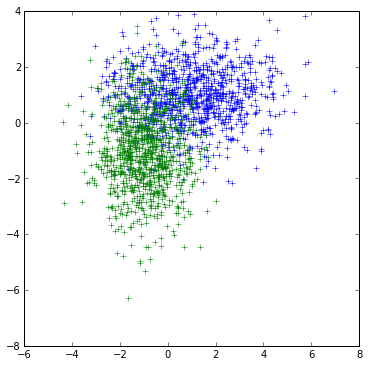

In [7]:
figsize(6,6)
plot(samples0[:,0],samples0[:,1],'+')
plot(samples1[:,0],samples1[:,1],'+')

# Parameter Estimation

(means and variances)

If we knew the parameters $(\mu_i,\Sigma_i)$, we could perform optimal classification.

However, in practice, we need to estimate these parameters.  We use the usual formulas for this.

$\hat{\mu} = \frac{1}{N} \sum_{r=1}^N x^{(r)}$

Here, $x^{(r)}$ is training sample $r$.  
Remember that $x\in R^2$, so $x = (x_0,x_1)$.

The general definition of the empirical covariance is:

$\hat{\Sigma}_{ij} = \frac{1}{N} \sum (x_i^{(r)}-\hat{\mu}_i) (x_j^{(r)}-\hat{\mu}_j)$

(diagonal covariance matrices)

However, of special importance are _diagonal covariance matrices_.

For these, we assume that only the diagonal elements of the covariance matrix are non-zero.

This is also the same as just computing the variances for each dimension separately:

$\hat{\Sigma} = \hbox{diag}(\sigma_1^2,...,\sigma_d^2)$

where

$\sigma_i^2 = \sum_{i=1}^N (x_i^{(r)} - \hat{\mu}_i)^2$


There are simple built-in functions for computing the means and covariances.



In [8]:
mean0 = mean(samples0,axis=0)
sigma0 = var(samples0,axis=0)
mean0,sigma0

(array([ 0.96306184,  0.99597855]), array([ 2.92315936,  0.99367374]))

Remember that the true values are (1,1) and (3,1), so these are pretty good estimates.

Let's repeat this for class 1.

In [9]:
mean1 = mean(samples1,axis=0)
sigma1 = var(samples1,axis=0)
mean1,sigma1

(array([-0.99250469, -0.99305026]), array([ 1.06366716,  1.92246796]))

We can now plot the corresponding densities.

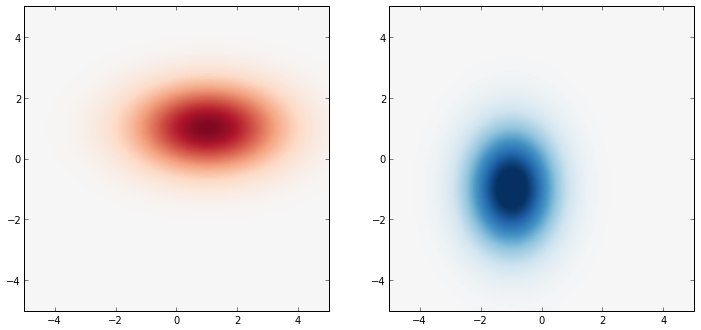

In [13]:
figsize(12,6); subplot(121)
imshow(-G(normal(grid,mu0,diag(sigma0))),origin='lower',extent=(-5,5,-5,5),cmap=cm.RdBu,vmin=-0.1,vmax=0.1)
subplot(122)
imshow(G(normal(grid,mu1,diag(sigma1))),origin='lower',extent=(-5,5,-5,5),cmap=cm.RdBu,vmin=-0.1,vmax=0.1)

We can overlay the original samples on top of this.



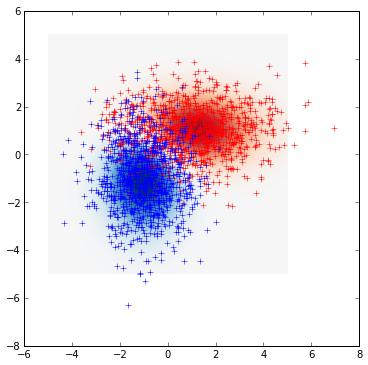

In [14]:
imshow(-G(normal(grid,mu0,diag(sigma0)))+G(normal(grid,mu1,diag(sigma1))),
       origin='lower',extent=(-5,5,-5,5),cmap=cm.RdBu,vmin=-0.1,vmax=0.1)
plot(samples0[:,0],samples0[:,1],'r+')
plot(samples1[:,0],samples1[:,1],'b+')

How do we take advantage of knowledge of knowledge of the densities?

$$ P(c|x) = \frac{ p(x|c) P(c) } { p(x) } $$

Recall that any given $x$, we decide that the class that maximizes the posterior is the class that we want. The decision is independent of $p(x)$. Also, we have equal priors, $P(c=0)=P(c=1)$.

So, we just compare:

$$ g_0(x) = p(x|c=0) $$
$$ g_1(x) = p(x|c=1) $$

We call these functions _discriminant functions_.

The _decision function_ is:

$$ D(x) = \arg\max g_c(x) $$


Let's plot these decision regions.



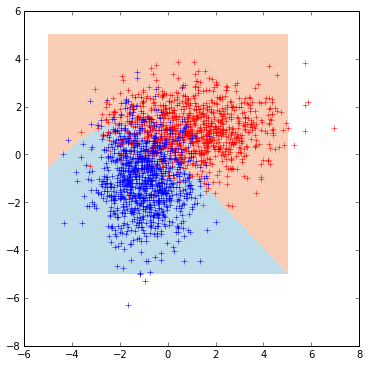

In [19]:
imshow((G(normal(grid,mu0,diag(sigma0)))<G(normal(grid,mu1,diag(sigma1))))-0.5,
       origin='lower',extent=(-5,5,-5,5),cmap=cm.RdBu,vmin=-2,vmax=2)
plot(samples0[:,0],samples0[:,1],'r+')
plot(samples1[:,0],samples1[:,1],'b+')

Full Covariances
================

Above, we used diagonal covariance matrices:

$$\Sigma = \hbox{diag}(\sigma_1^2 ... \sigma_d^2) = 
\begin{pmatrix} 
\sigma_1^2 & 0 & ... & 0 \\\ 
\vdots & \ddots & & \vdots \\\
0 & ... & \sigma_{d-1}^2 & 0 \\\ 
0 & ... & 0 & \sigma_d^2 
\end{pmatrix}$$

That matrix is just a diagonal matrix with the variance of each variable separately along the diagonal.

A full covariance matrix has non-zero entries everywhere:

$$
\Sigma = 
\begin{pmatrix} 
\Sigma_{1,1} & \Sigma_{1,2} & ... & \Sigma_{1,d} \\\ 
\vdots          & \ddots    &                & \vdots \\\          
\Sigma_{2,1} & ... & \Sigma_{2,d-1} & \Sigma_{2,d} \\\   
\Sigma_{d,1} & ... & \Sigma_{d,d-1} & \Sigma_{d,d} 
\end{pmatrix}
$$

We already have given the formula for estimating this from data:

$\hat{\Sigma}_{ij} = \frac{1}{N} \sum (x_i^{(r)}-\hat{\mu}_i) (x_j^{(r)}-\hat{\mu}_j)$

Python provides the `cov` function for estimating covariances.
Note that it computes the covariances of column vectors of an array,
but we want covariances of row vectors, so we need to transpose.

In [23]:
# covariances
sigma0 = cov(samples0.T)
sigma1 = cov(samples1.T)
print sigma0
print sigma1

[[ 2.92608545  0.05090811]
 [ 0.05090811  0.99466841]]
[[ 1.06473189 -0.04311753]
 [-0.04311753  1.92439235]]


Since the true covariance matrices are diagonal,
these estimates have small off-diagonal entries.
However, these entries are not quite zero.

Note that the number of covariance parameters we need
to estimate from data grows quadratically in the number
of dimensions.
There is often simply not enough data to estimate a full
covariance matrix reliably.

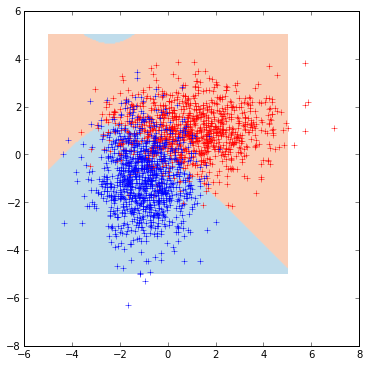

In [25]:
# full covariance matrices
imshow((G(normal(grid,mu0,sigma0))<G(normal(grid,mu1,sigma1)))-0.5,
       origin='lower',extent=(-5,5,-5,5),cmap=cm.RdBu,vmin=-2,vmax=2)
plot(samples0[:,0],samples0[:,1],'r+')
plot(samples1[:,0],samples1[:,1],'b+')



That decision region is slightly different from what we got
with a purely diagonal covariance matrix.
In higher dimensions, those differences become much larger.

(prior knowledge)

Note that we have two forms of _prior knowledge_:

- parametric knowledge, e.g., the prior probability of each class

- structural knowledge, e.g., that the ccd's are Gaussian and that the covariance matrices are diagonal

If our prior knowledge is too limited or our assumptions are wrong, classification accuracy drops.

Limited prior knowledge can be compensated with more data (eventually, we figure out that the covariance matrix is diagonal).

Erroneous prior assumptions cannot be fixed with more data.